<a href="https://colab.research.google.com/github/ealbenque/eurocode_3_steel/blob/main/EC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###dependencies



In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import seaborn as sns

scaler = MinMaxScaler()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [88]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/ealbenque/eurocode_3_steel/main/src/models/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [89]:
file_path = "https://github.com/ealbenque/eurocode_3_steel/raw/main/data/raw/EC3-section_and_stability.xls"

df = pd.read_excel(file_path,sheet_name='IPE_simple')
df = df[['section','Iy','Wy']]
df = df.drop(axis=0, index=0)
df

,section,Iy,Wy
1,IPE 80,801400,20030
2,IPE100,1710000,34200
3,IPE120,3178000,52960
4,IPE140,5412000,77320
5,IPE160,8693000,108700
6,IPE180,13170000,146300
7,IPE200,19430000,194300
8,IPE220,27720000,252000
9,IPE240,38920000,324300
10,IPE270,57900000,428900


###generation of training data

In [90]:
X = np.empty((0,2))
y = np.empty(0,dtype=int)
z = np.empty((0,),dtype=str)

crit = 200
L_list = np.linspace(2,15,num=100)
p_list = np.linspace(100,10000,num=100)
E_s = 210000000000 #Pa = N/m²
f_y = 235000000 #Pa = N/m²
section_check = 0

for L in L_list :
    i= 1
    for p in p_list:
        section_check = 0
        while (section_check ==0) & (i <= len(df)+1) :
            S_i = df.loc[i,'section']
            I_y_i = df.loc[i,'Iy']
            crit_i = 384 * E_s*I_y_i*10**(-12)/(5 *p*L**3)
            if crit_i>crit:
                section_check = 1
                X = np.append(X,[[L,p]],axis=0)
                y = np.append(y,i)
                z = np.append(z,[S_i],axis=0)
            else:
                i+=1

In [91]:
print(len(df))

17


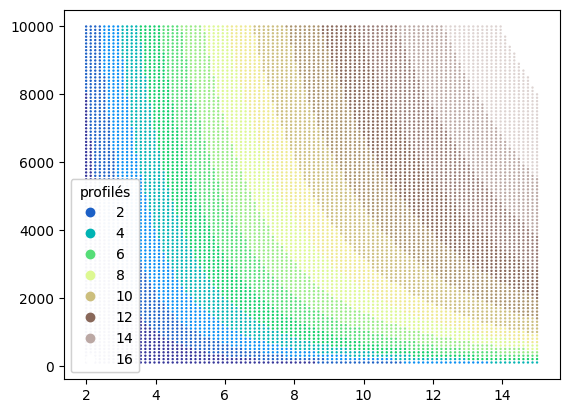

In [92]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:,0],X[:,1], c=y[:], cmap='terrain',s=0.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="profilés")
ax.add_artist(legend1)

plt.show()

In [93]:
X = scaler.fit_transform(X)
print(X)

[[0.         0.        ]
 [0.         0.01010101]
 [0.         0.02020202]
 ...
 [1.         0.97979798]
 [1.         0.98989899]
 [1.         1.        ]]


###build model

In [94]:
# Set the hyperparameters
NUM_CLASSES = 17
NUM_FEATURES = 2
RANDOM_SEED = 42

In [95]:
print(y[:500])
print(X)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 

tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        [0.0000, 0.0303],
        [0.0000, 0.0404]]) tensor([1, 1, 1, 1, 1])


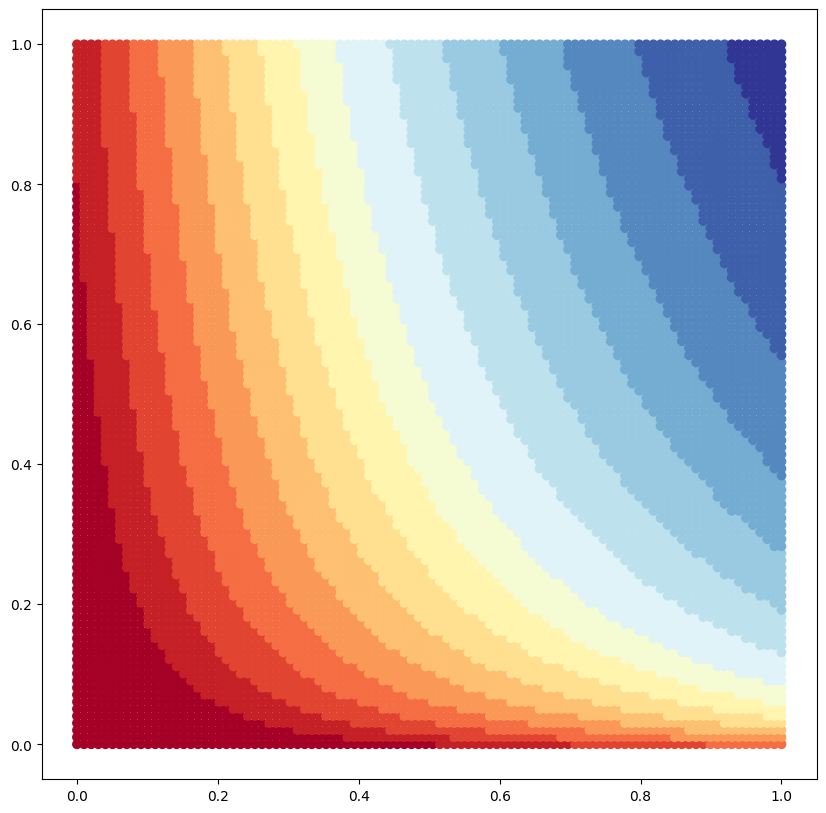

In [96]:
# 2. Turn data into tensors
X_ = torch.from_numpy(X).type(torch.float)
y_ = torch.from_numpy(y).type(torch.LongTensor)
print(X_[:5], y_[:5])

# 3. Split into train and test sets
X__train, X__test, y__train, y__test = train_test_split(X_,
    y_,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 10))
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=plt.cm.RdYlBu);

In [97]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [98]:
# Build model
class Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of Model and send it to the target device
model_4 = Model(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=128).to(device)
model_4

Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=17, bias=True)
  )
)

In [99]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.01)

In [100]:
# How many elements in a single prediction sample?
model_4(X__train.to(device))[0].shape, NUM_CLASSES

(torch.Size([17]), 17)

In [101]:
# Make prediction logits with model
y_logits = model_4(X__test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0464,  0.0374, -0.1381, -0.0096, -0.0063,  0.0037,  0.0051,  0.0502,
          0.0342,  0.0284,  0.0133, -0.1089, -0.2144,  0.0079, -0.2352, -0.0084,
          0.0458],
        [-0.0217,  0.0661, -0.0977, -0.0431,  0.0136, -0.0289,  0.0305,  0.0464,
          0.0227,  0.0460,  0.0213, -0.0822, -0.2237, -0.0079, -0.2627, -0.0490,
          0.0443],
        [-0.0708,  0.0736, -0.1093, -0.0519,  0.0121, -0.0538,  0.0668,  0.0751,
          0.0655,  0.0615,  0.0250, -0.0794, -0.1770, -0.0544, -0.1786, -0.0131,
          0.0826],
        [-0.0504,  0.0478, -0.1354, -0.0258, -0.0063, -0.0278,  0.0286,  0.0696,
          0.0453,  0.0281,  0.0174, -0.0976, -0.1966, -0.0144, -0.2077, -0.0099,
          0.0614],
        [-0.0783,  0.0465, -0.1426, -0.0277, -0.0050, -0.0125,  0.0382,  0.0844,
          0.0554,  0.0389,  0.0276, -0.1138, -0.1945, -0.0294, -0.1773, -0.0009,
          0.0811]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[0.0578, 0.0628, 0.0527, 0.0599, 0.0601, 0.

In [102]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [103]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0578, 0.0628, 0.0527, 0.0599, 0.0601, 0.0607, 0.0608, 0.0636, 0.0626,
        0.0623, 0.0613, 0.0543, 0.0488, 0.0610, 0.0478, 0.0600, 0.0633],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7, device='cuda:0')


In [104]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 50000

# Put data to target device
X__train, y__train = X__train.to(device), y__train.to(device)
X__test, y__test = X__test.to(device), y__test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X__train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y__train)
    acc = accuracy_fn(y_true=y__train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X__test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y__test)
      test_acc = accuracy_fn(y_true=y__test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.84394, Acc: 5.64% | Test Loss: 2.84571, Test Acc: 5.15%
Epoch: 100 | Loss: 2.78491, Acc: 8.60% | Test Loss: 2.78685, Test Acc: 8.10%
Epoch: 200 | Loss: 2.74455, Acc: 8.60% | Test Loss: 2.74642, Test Acc: 8.10%
Epoch: 300 | Loss: 2.71094, Acc: 8.60% | Test Loss: 2.71268, Test Acc: 8.10%
Epoch: 400 | Loss: 2.67892, Acc: 9.29% | Test Loss: 2.68028, Test Acc: 9.10%
Epoch: 500 | Loss: 2.64434, Acc: 12.51% | Test Loss: 2.64491, Test Acc: 13.05%
Epoch: 600 | Loss: 2.60509, Acc: 17.75% | Test Loss: 2.60457, Test Acc: 17.90%
Epoch: 700 | Loss: 2.55956, Acc: 20.36% | Test Loss: 2.55769, Test Acc: 20.35%
Epoch: 800 | Loss: 2.50710, Acc: 22.04% | Test Loss: 2.50373, Test Acc: 21.95%
Epoch: 900 | Loss: 2.44878, Acc: 22.80% | Test Loss: 2.44387, Test Acc: 22.35%
Epoch: 1000 | Loss: 2.38726, Acc: 23.47% | Test Loss: 2.38096, Test Acc: 23.35%
Epoch: 1100 | Loss: 2.32556, Acc: 25.44% | Test Loss: 2.31810, Test Acc: 25.00%
Epoch: 1200 | Loss: 2.26627, Acc: 31.42% | Test Loss: 2.25804,

In [105]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X__test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -29.3182, -171.6305, -140.3338,  -99.6273,  -60.2881,  -27.5944,
           -1.6001,   19.5451,   43.3497,   61.9409,   75.7218,   80.0889,
           73.9202,   63.0873,   41.0995,   28.7920,   29.5498],
        [ -30.0180, -146.9235, -115.9052,  -78.7459,  -42.6520,  -13.0612,
            9.8744,   27.9283,   47.3794,   61.3880,   69.7062,   68.1078,
           55.8735,   43.6885,   16.3623,    3.2667,   10.1868],
        [ -29.4127,  110.5936,  119.2447,  124.8604,  124.6689,  118.5565,
          106.4129,   86.4061,   69.9547,   43.2099,    4.4578,  -46.6607,
         -108.8230, -136.1634, -193.8033, -209.7625, -186.4859],
        [ -29.1544,  -73.9060,  -51.4986,  -25.3274,    2.1133,   23.6038,
           39.2491,   49.7758,   57.2270,   58.2902,   52.1391,   35.5468,
            9.4478,   -7.9816,  -42.8566,  -56.4799,  -49.5711],
        [ -27.6097,    5.2628,   19.0534,   33.3065,   49.0830,   59.6810,
           65.3672,   66.0558,   61.1915,   49.8224,   30.5065,  

In [106]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y__test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y__test, y_pred=y_preds)}%")

Predictions: tensor([11, 10,  3,  9,  7, 10,  3,  3, 12,  2], device='cuda:0')
Labels: tensor([11, 10,  3,  9,  7, 10,  3,  3, 12,  1], device='cuda:0')
Test accuracy: 95.5%


In [107]:
X_plot_train = X__train
y_plot_train = y__train
X_plot_test = X__test
y_plot_test = y__test

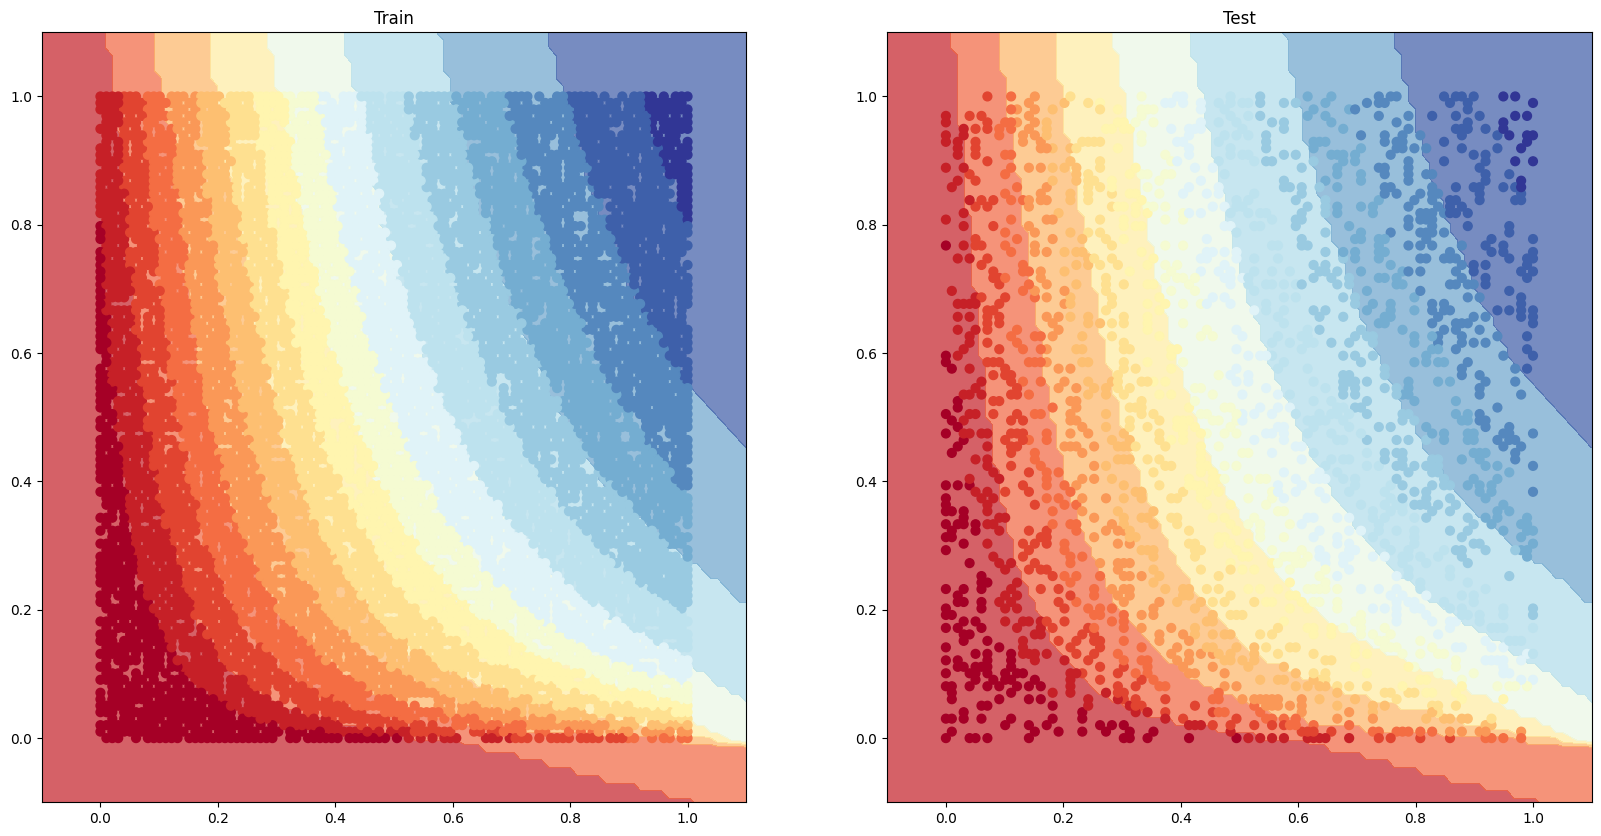

In [108]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_plot_train, y_plot_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_plot_test, y_plot_test)